<a href="https://colab.research.google.com/github/kenneth-craig/academyPub/blob/main/vehicle_load_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -q kaggle
from google.colab import files
files.upload()
#create a kaggle folder
!mkdir ~/.kaggle

# Go on kaggle > Account > Create New API token
# Save the json file in your laptop in a dedicated folder

# copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# Datasets available here: 
# https://www.kaggle.com/avikpaul4u/vehicle-loan-default-prediction
!kaggle datasets download -d avikpaul4u/vehicle-loan-default-prediction
!unzip vehicle-loan-default-prediction.zip
# https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009
!unzip red-wine-quality-cortez-et-al-2009.zip

Saving kaggle.json to kaggle.json
 95% 11.0M/11.6M [00:00<00:00, 15.2MB/s]
100% 11.6M/11.6M [00:00<00:00, 17.1MB/s]
Archive:  vehicle-loan-default-prediction.zip
  inflating: Data Dictionary.xlsx    
  inflating: test.csv                
  inflating: train.csv               
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 43.1MB/s]
Archive:  red-wine-quality-cortez-et-al-2009.zip
  inflating: winequality-red.csv     


In [8]:
!pwd
!ls

/content
'Data Dictionary.xlsx'			  test.csv
 kaggle.json				  train.csv
 red-wine-quality-cortez-et-al-2009.zip   vehicle-loan-default-prediction.zip
 sample_data				  winequality-red.csv


In [9]:
# Here is a sumup of all the manipulation we did in order to load the dataset 
# and to add some complexity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import seaborn as sns
import itertools
import scipy.stats as ss
from imblearn.over_sampling import SMOTE

In [ ]:
# Skip generating new FEATURE for now
"""
def citric_acid_cat(x):
  if x < 0.21 :
    return 'A'
  elif x < 0.3 :
    return 'B'
  else:
    return 'C'
"""

In [10]:
df = pd.read_csv('/content/train.csv')

In [ ]:
#df.PERFORM_CNS_SCORE.max()
df.PERFORM_CNS_SCORE.mean()
#df.PERFORM_CNS_SCORE.median()
#df.PERFORM_CNS_SCORE.min()
#df.head(3)
#df.dtypes

289.46299441570807

In [ ]:
"""
Skip feature engineering for now for Vehicle Loan analysis
df['citric_cat'] = df['citric acid'].apply(lambda x: citric_acid_cat(x))
df['Y'] = np.where(df['quality']>= 7, 1, 0)
df['fixed_acidity_cat'] = np.where(df['fixed acidity']<= 8, 0, 1)
df['volatile_acidity_cat'] = np.where(df['volatile acidity']>= 0.4, 0, 1)
temp = df.sample(n=150, random_state=919640901)
df = df.append(temp)
del(temp)
df.reset_index(drop=True, inplace=True)
df['pH2'] = np.where(df['pH'].index %15 ==0, np.nan, df['pH'])
rng = np.random.default_rng(893717398)
df = df.join(pd.Series(rng.normal(df['fixed acidity'].median(),1,len(df)), name='acidity_other'))
df['acidity_other'] = np.where(df['acidity_other'].index %2 !=0, np.nan, df['pH'])
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 
"""

In [11]:
def random_datetimes_or_dates(start, end, out_format='datetime', n=10): 

    '''   
    unix timestamp is in ns by default. 
    I divide the unix time value by 10**9 to make it seconds 
    (or 24*60*60*10**9 to make it days).
    The corresponding unit variable is passed to 
    the pd.to_datetime function. 
    Values for the (divide_by, unit) pair to select is defined by 
    the out_format parameter.
    for 1 -> out_format='datetime'
    for 2 -> out_format=anything else
    '''
    (divide_by, unit) = (10**9, 's') if out_format=='datetime' else (24*60*60*10**9, 'D')

    start_u = start.value//divide_by
    end_u = end.value//divide_by

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit=unit)

In [12]:

#PART OF SAME CODE BLOCK (PROCESS) AS TWO PREVIOUS BLOCKS
np.random.seed(919640901)
d_start = pd.to_datetime('2021-01-01')
d_end = pd.to_datetime('2021-06-30')
df['date'] = random_datetimes_or_dates(d_start, d_end, out_format='datetime', n=len(df))
df['date'] = df['date'].astype(str)

#df['citric_cat'] = np.where(df['citric_cat'] == 'C', 'Z', df['citric_cat']) # DO LATER
df['date'] = pd.to_datetime(df['date'], format= '%Y-%m-%d %H:%M:%S') 
today = pd.to_datetime('2021-10-12', format = '%Y-%m-%d')
df['time_diff'] = today - df['date']
df['day_diff'] = (df['time_diff']/np.timedelta64(1, 'D')).astype(float)
np.random.seed(919640901)
randomf1 = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
randomf2 = pd.Series(np.random.normal(1, 0.5, len(df)), name='Random_Normal_feature2')
randomf = pd.concat([randomf1, randomf2], axis=1, ignore_index=True)
randomf.columns = ['Random_Normal_feature1', 'Random_Normal_feature2']
np.random.seed(919640901)
df['Random_Normal_feature1'] = pd.Series(np.random.normal(0, 1, len(df)), name='Random_Normal_feature1')
df = df.merge(randomf, how='inner', on='Random_Normal_feature1')


In [ ]:
#df.head(3)
df.dtypes

In [ ]:
# First of all, we need to split the data base into 3 parts:
# - One for the training part
# - One for the validation part
# - One for the temporal validation part (OOT: Out Of Time)

# Let's do the first temporal split:

In [13]:
# We already parsed our date feature previously (you can check with dtypes)
# Let's see the monthly number of observation
df.set_index('date').resample('M').size()

date
2021-01-31    40173
2021-02-28    36109
2021-03-31    40188
2021-04-30    38651
2021-05-31    40343
2021-06-30    37690
Freq: M, dtype: int64

In [14]:
# We will use the 2 last months for the OOT validation
oot = df[df['date'] >= '2021-05-01']
# You can check if it works as you want: oot.date.min()

# Now we will keep the database without the oot:
df = df[df['date'] < '2021-05-01']
# And we will randomly split this data base in 2, one for the train and the other for the test
# As you notice we will have to validation database.
# One based on the same distribution as the train and the other from another distribution


# The random split is used with the sklean library, I decided to have 75% in train and 25% in test
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=919640901)

In [15]:
#train.dtypes
#test.dtypes
#oot.shape
#df.shape
#test.shape
train.shape

(116340, 46)

In [ ]:
#print(train)
#print(test)
train.head(3)
#test.head(3)
#train.shape
#test.shape
#train.DISBURSED_AMOUNT.max()
#train.ASSET_COST.max()

In [16]:
# Let's see if we have duplicated rows:
feature_analyze_duplicates = ['LOAN_DEFAULT', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV',
                              'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
                              'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
                              'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']

len(train[train.duplicated(subset = feature_analyze_duplicates, keep=False)])

def drop_duplicate_keep_first(database, list_of_features):
  database = database.drop_duplicates(subset= list_of_features, keep='first')
  return database

train = drop_duplicate_keep_first(train, feature_analyze_duplicates)

In [44]:
#train.shape
#train.dtypes
#train.SEC_INSTAL_AMT.mean()
#train.SEC_INSTAL_AMT.median()
#train.SEC_INSTAL_AMT.min()
train.SEC_INSTAL_AMT.max()


1814000

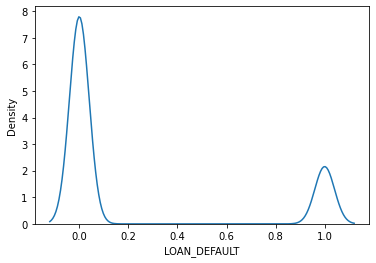

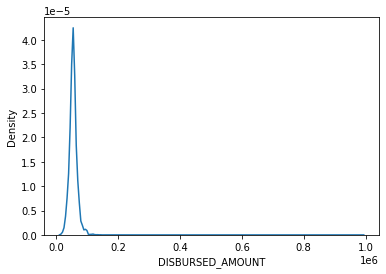

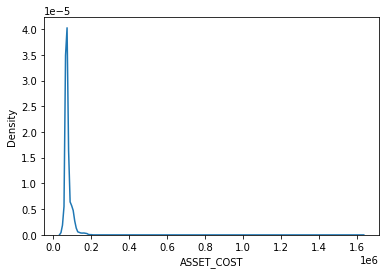

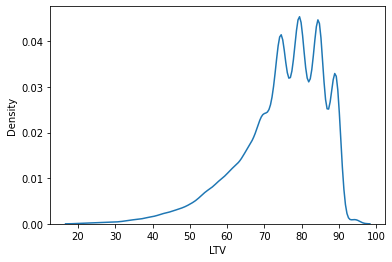

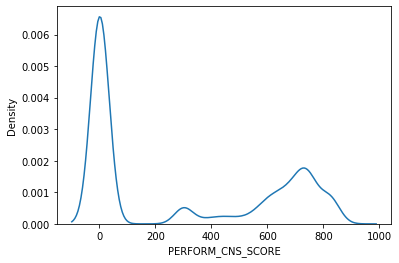

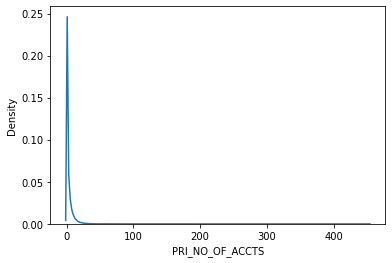

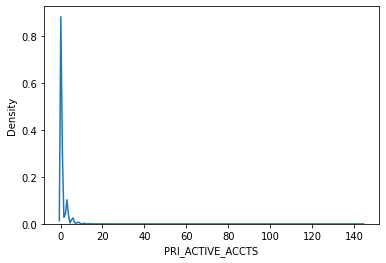

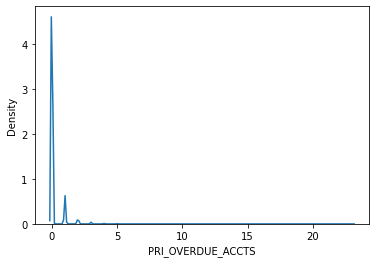

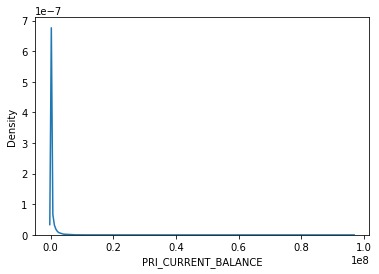

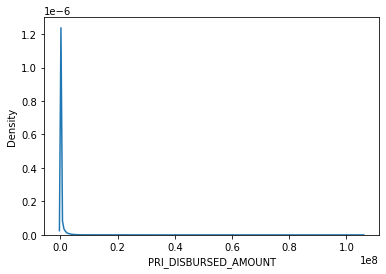

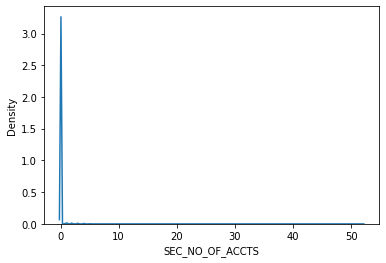

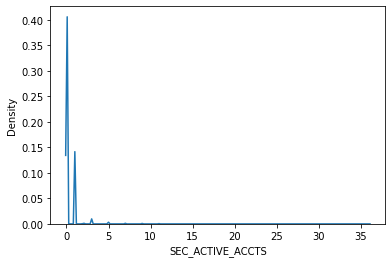

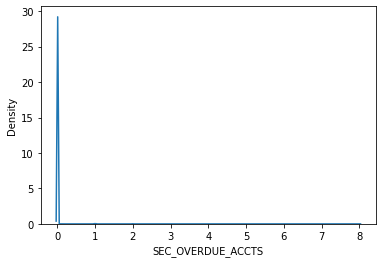

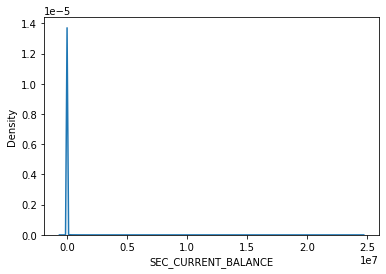

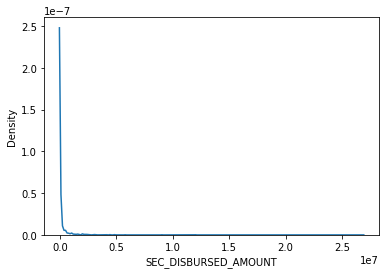

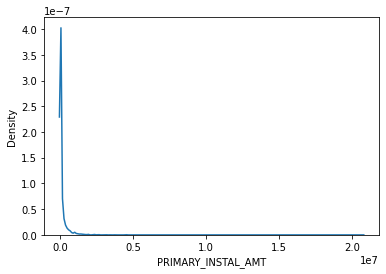

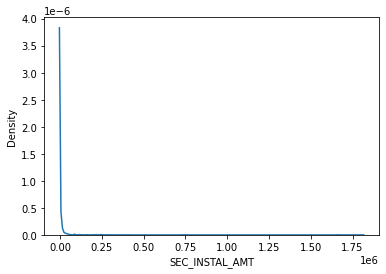

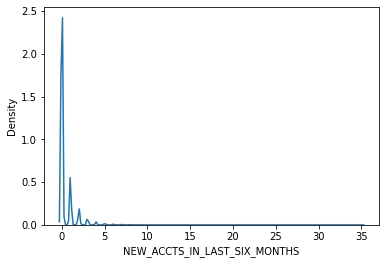

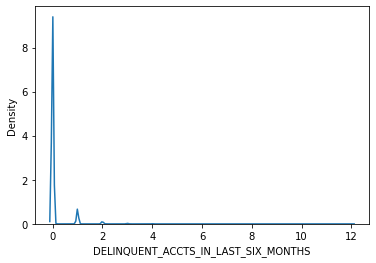

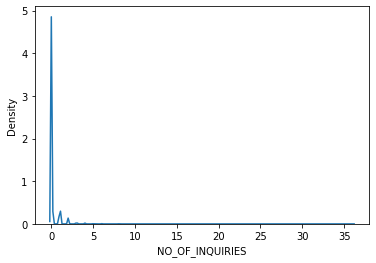

In [26]:
# Let's see the features distributions in order to see if we have strange / extrem values
# Excluded PRI_SANCTIONED_AMOUNT, SEC_SANCTIONED_ACCTS, SEC_ACTIVE_ACCTS, SEC_DISBURSED_AMOUNT
continuous_feature_analyze_distribution = ['LOAN_DEFAULT', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV',
                                           'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
                                           'PRI_CURRENT_BALANCE', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
                                           'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
                                           'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']

# Plots of individual Features
for i, col in enumerate(train[continuous_feature_analyze_distribution]):
  plt.figure(i)
  sns.kdeplot(x=col, data=train)

In [13]:
def positive_censure(database, feature_to_censure, value_censure):
  feature = np.where(database[feature_to_censure] >= value_censure, value_censure, database[feature_to_censure])
  return feature

['LOAN_DEFAULT', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV',
                                           'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
                                           'PRI_CURRENT_BALANCE', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
                                           'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
                                           'SEC_ACTIVE_ACCTS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']

train['DISBURSED_AMOUNT'] = positive_censure(train, 'DISBURSED_AMOUNT', 100000)
train['ASSET_COST'] = positive_censure(train, 'ASSET_COST', 130000)
train['PRI_NO_OF_ACCTS'] = positive_censure(train, 'PRI_NO_OF_ACCTS', 20)
train['PRI_ACTIVE_ACCTS'] = positive_censure(train, 'PRI_ACTIVE_ACCTS', 10)
train['PRI_OVERDUE_ACCTS'] = positive_censure(train, 'PRI_OVERDUE_ACCTS', 4)
train['PRI_CURRENT_BALANCE'] = positive_censure(train, 'PRI_CURRENT_BALANCE', 200000)
# Will ignore SANCTION_AMT due to influence being > 0.95 & plots look the same
#train['PRI_SANCTIONED_AMOUNT'] = positive_censure(train, 'PRI_SANCTIONED_AMOUNT', 250000)
# Will ignore PRI_DISBURSED_AMT due to influence being > 0.95
train['PRI_DISBURSED_AMOUNT'] = positive_censure(train, 'PRI_DISBURSED_AMOUNT', 250000) 
train['SEC_NO_OF_ACCTS'] = positive_censure(train, 'SEC_NO_OF_ACCTS', 10)
train['SEC_ACTIVE_ACCTS'] = positive_censure(train, 'SEC_ACTIVE_ACCTS', 5)
train['SEC_OVERDUE_ACCTS'] = positive_censure(train, 'SEC_OVERDUE_ACCTS', 1)
train['SEC_CURRENT_BALANCE'] = positive_censure(train, 'SEC_CURRENT_BALANCE', 7000)
# Will ignore SANCTION_AMT due to influence being > 0.95 & plots look the same
#train['SEC_SANCTIONED_AMOUNT'] = positive_censure(train, 'PRI_SANCTIONED_AMOUNT', 250000)
# Will ignore SEC_DISBURSED_AMT due to influence being > 0.95
train['SEC_DISBURSED_AMOUNT'] = positive_censure(train, 'SEC_DISBURSED_AMOUNT', 8000)
train['PRIMARY_INSTAL_AMT'] = postive_centure(train, 'PRIMARY_INSTAL_AMT', ???) 
train['SEC_INSTAL_AMT'] = postive_centure(train, 'SEC_INSTAL_AMT', ???) 
train['NEW_ACCTS_IN_LAST_SIX_MONTHS'] = positive_censure(train, 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 6)
train['DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'] = positive_censure(train, 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 3)
train['NO_OF_INQUIRIES'] = positive_censure(train, 'NO_OF_INQUIRIES', 5)


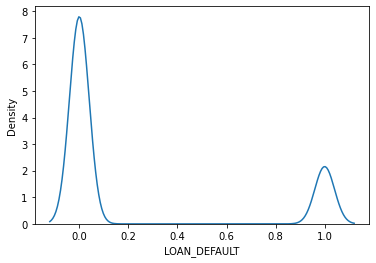

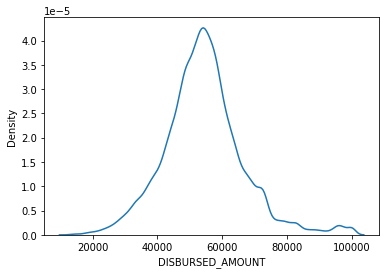

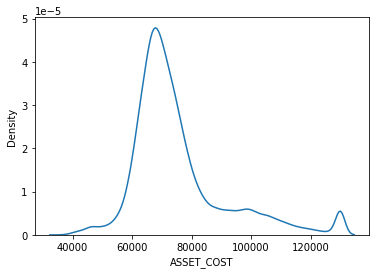

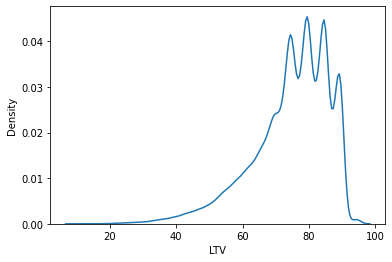

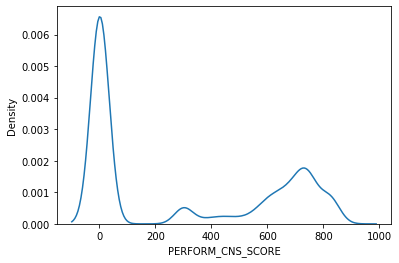

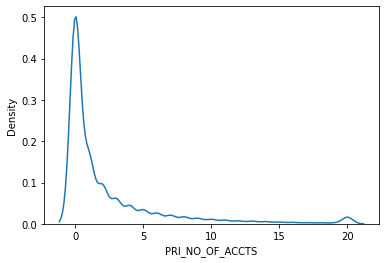

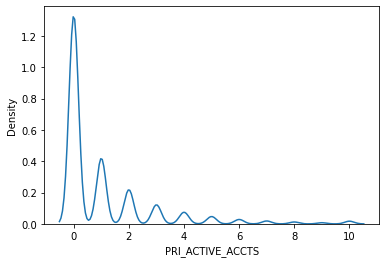

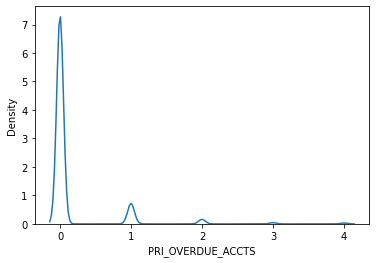

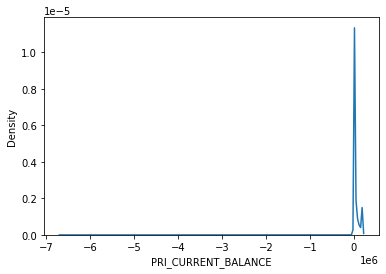

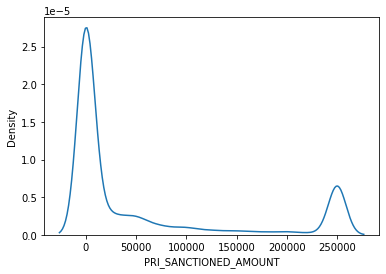

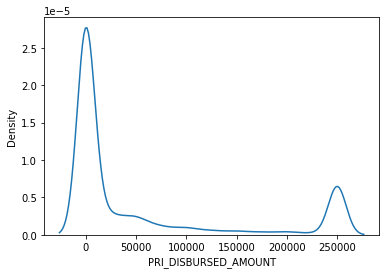

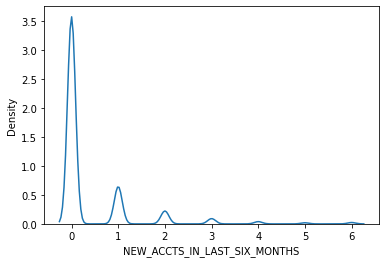

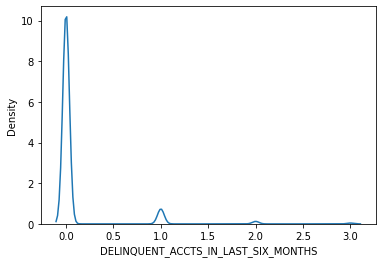

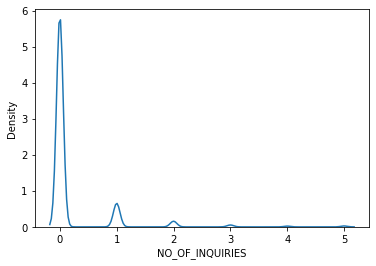

In [14]:
# Let's see the features distributions in order to see if we have strange / extrem values
continuous_feature_analyze_distribution = ['LOAN_DEFAULT', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV',
                                           'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
                                           'PRI_CURRENT_BALANCE', 'PRI_DISBURSED_AMOUNT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
                                            'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES']
                                            
# Plots of individual Features
for i, col in enumerate(train[continuous_feature_analyze_distribution]):
  plt.figure(i)
  sns.kdeplot(x=col, data=train)

In [21]:
def negative_censure(database, feature_to_censure, value_censure):
  feature = np.where(database[feature_to_censure] <= value_censure, value_censure, database[feature_to_censure])
  return feature

train['LTV'] = negative_censure(train, 'LTV', 20)
train['PRI_CURRENT_BALANCE'] = negative_censure(train, 'PRI_CURRENT_BALANCE', -0.01)

# Plots of individual Features
for i, col in enumerate(train[continuous_feature_analyze_distribution]):
  plt.figure(i)
  sns.kdeplot(x=col, data=train)

NameError: ignored

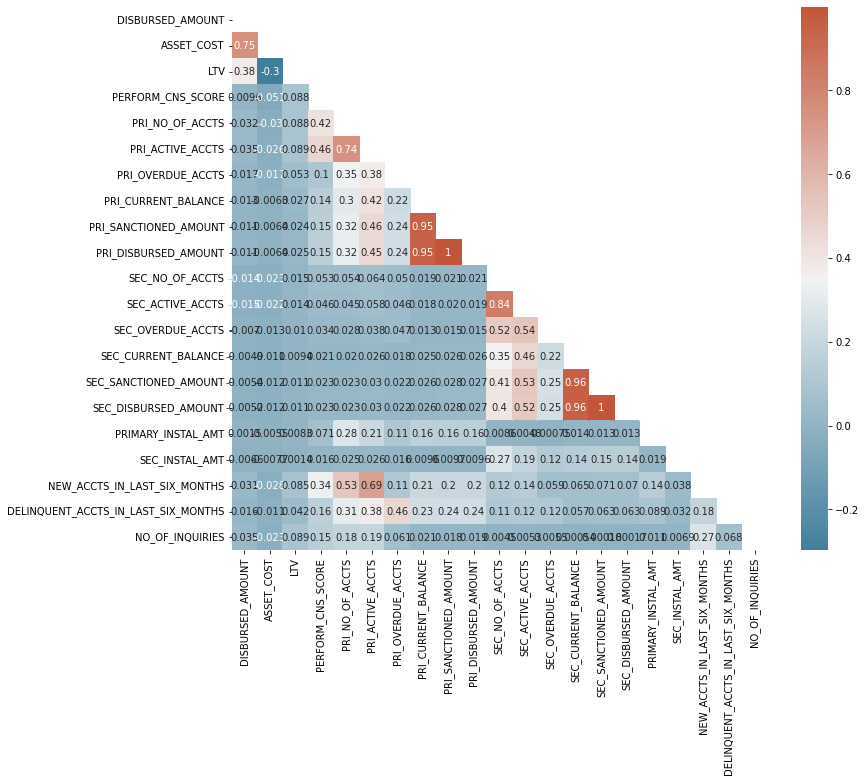

In [ ]:
# Now let's analyze the correlations between the quantitative features
# Keep in mind that binary features are not quantitative !!!

# Default Loan Features for correlation
# DISBURSED_AMOUNT
# ASSET_COST
# LTV
# PERFORM_CNS_SCORE
# PRI_NO_OF_ACCTS
# PRI_ACTIVE_ACCTS
# PRI_OVERDUE_ACCTS
# PRI_CURRENT_BALANCE
# PRI_SANCTIONED_AMOUNT
# PRI_DISBURSED_AMOUNT
# SEC_NO_OF_ACCTS
# SEC_ACTIVE_ACCTS
# SEC_OVERDUE_ACCTS
# SEC_CURRENT_BALANCE
# SEC_SANCTIONED_AMOUNT
# SEC_DISBURSED_AMOUNT
# PRIMARY_INSTAL_AMT
# SEC_INSTAL_AMT
# NEW_ACCTS_IN_LAST_SIX_MONTHS
# DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS
# AVERAGE_ACCT_AGE
# CREDIT_HISTORY_LENGTH
# NO_OF_INQUIRIES

feature_analyze_correlation = ['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'PERFORM_CNS_SCORE',
       'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_DISBURSED_AMOUNT',
       'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'NO_OF_INQUIRIES'
       ]
# NEED TO TURN 'AVERAGE_ACCT_AGE' & 'CREDIT_HISTORY_LENGTH' INTO MONTHS, not Years & Months

# Get all the correlations:
corr = train[feature_analyze_correlation].corr()
#
# Set up the matplotlib plot configuration
fig, ax = plt.subplots(figsize=(12, 10))
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# We can see on the heatmap that we don't have a features having a high correlation (>0.8)
# As a result we can keep them all